## Assess the novelty of the Li Dataset

In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from distance import *
from mi_density import *
from utils import *

from pymatgen.core import Structure

import textalloc as ta
import matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mpl_style
import matplotlib.gridspec as gridspec

fpath = Path("/Users/andrewf/Library/Fonts/dejavu-sans.condensed.ttf")
mpl.font_manager.fontManager.addfont(fpath)
if fpath.exists():
    # Add the font to the font manager
    mpl.font_manager.fontManager.addfont(str(fpath))

    # Create font properties object
    prop = mpl.font_manager.FontProperties(fname=str(fpath))
    font_name = prop.get_name()

    # Set as default
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = [font_name]

    # Set specific text properties
    # For newer matplotlib versions
    mpl.rc("font", **{"family": "sans-serif", "sans-serif": [font_name]})

    def apply_condensed_font(fig):
        for ax in fig.axes:
            # Apply to all text elements on the axes
            for text in ax.texts:
                text.set_fontproperties(prop)

            # Apply to title and axis labels
            ax.title.set_fontproperties(prop)
            ax.xaxis.label.set_fontproperties(prop)
            ax.yaxis.label.set_fontproperties(prop)

            # Apply to tick labels
            for label in ax.get_xticklabels():
                label.set_fontproperties(prop)
            for label in ax.get_yticklabels():
                label.set_fontproperties(prop)

            # Apply to legend if it exists
            legend = ax.get_legend()
            if legend:
                # Apply to legend title
                if legend.get_title():
                    legend.get_title().set_fontproperties(prop)

                # Apply to legend text
                for text in legend.get_texts():
                    text.set_fontproperties(prop)
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load formulas and structures from dataset folder.

In [3]:
MAT_DB = 'MP_Li_dataset'

structures = []
formulas = []
files = os.listdir(MAT_DB)
files = [file for file in files if ".cif" in file]
for filename in files:
    structure = Structure.from_file(os.path.join(MAT_DB, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))

mp = np.ones((len(structures)))

data = pd.DataFrame({'formula': formulas, 'structure': structures, 'filename': files, 'mp': mp})

MAT_DB = 'GNOME_Li_dataset'

structures = []
formulas = []
files = os.listdir(MAT_DB)
files = [file for file in files if ".cif" in file]
for filename in files:
    structure = Structure.from_file(os.path.join(MAT_DB, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))

mp = np.zeros((len(structures)))

# append to the data
data = pd.concat([data, pd.DataFrame({'formula': formulas, 'structure': structures, 'filename': files, 'mp': mp})], ignore_index=True)

### Load the distance matrices.

Optionally, you can re-generate them from the data (you might want to go make some coffee while you wait).

In [4]:
use_precomputed = True

if use_precomputed:
    lostop_dm = np.load("precomputed/Li_lostop_dm.npy")
    elmd_dm = np.load("precomputed/Li_elmd_dm.npy")
else:
    lostop_dm = get_lostop_dm(data["structure"].values)
    np.save("precomputed/Li_lostop_dm.npy", lostop_dm)

    elmd_dm = get_elmd_dm(data["formula"].values)
    np.save("precomputed/Li_elmd_dm.npy", elmd_dm)

### Compute the densities of GNOME materials against the MP corpus.

In [5]:
df = pd.DataFrame()
mi_data = {}

GNOME_idx = data[data['mp'] == 0].index
MP_idx = data[data['mp'] == 1].index

for dm, name in zip([lostop_dm, elmd_dm], ["lostop", "elmd"]):

    # only select rows and columns associated with MP materials
    filtered_dm = dm.copy()
    filtered_dm = filtered_dm[MP_idx][:, MP_idx]

    cutoff, mi_profile = get_MI_profile(filtered_dm, n_thresholds=200)
    mi_data[name] = [cutoff, mi_profile]

    print(f"MI cutoff for {name}: {cutoff}")

    dens = compute_mi_density(filtered_dm, cutoff, mi_profile)

    # now iteratively add the GNOME materials to the density matrix and append their density
    for G_idx in GNOME_idx:
        filtered_dm = dm.copy()
        # drop every other GNOME material except the one we are interested in from row and column
        filtered_dm = np.delete(filtered_dm, GNOME_idx[GNOME_idx != G_idx], axis=0)
        filtered_dm = np.delete(filtered_dm, GNOME_idx[GNOME_idx != G_idx], axis=1)

        dens_G = compute_mi_density(filtered_dm, cutoff, mi_profile)
        dens = np.concatenate((dens, np.array([dens_G[-1]])))

    df[f'{name}_density'] = dens

df['formula'] = data['formula']

MI cutoff for lostop: 2.4367534301084146
MI cutoff for elmd: 18.255648919597988


### Plot material densities along chemical and structural axes.

Note that the publication figure was adjusted post-hoc for visual clarity due to positioning issues with the `textalloc` library.

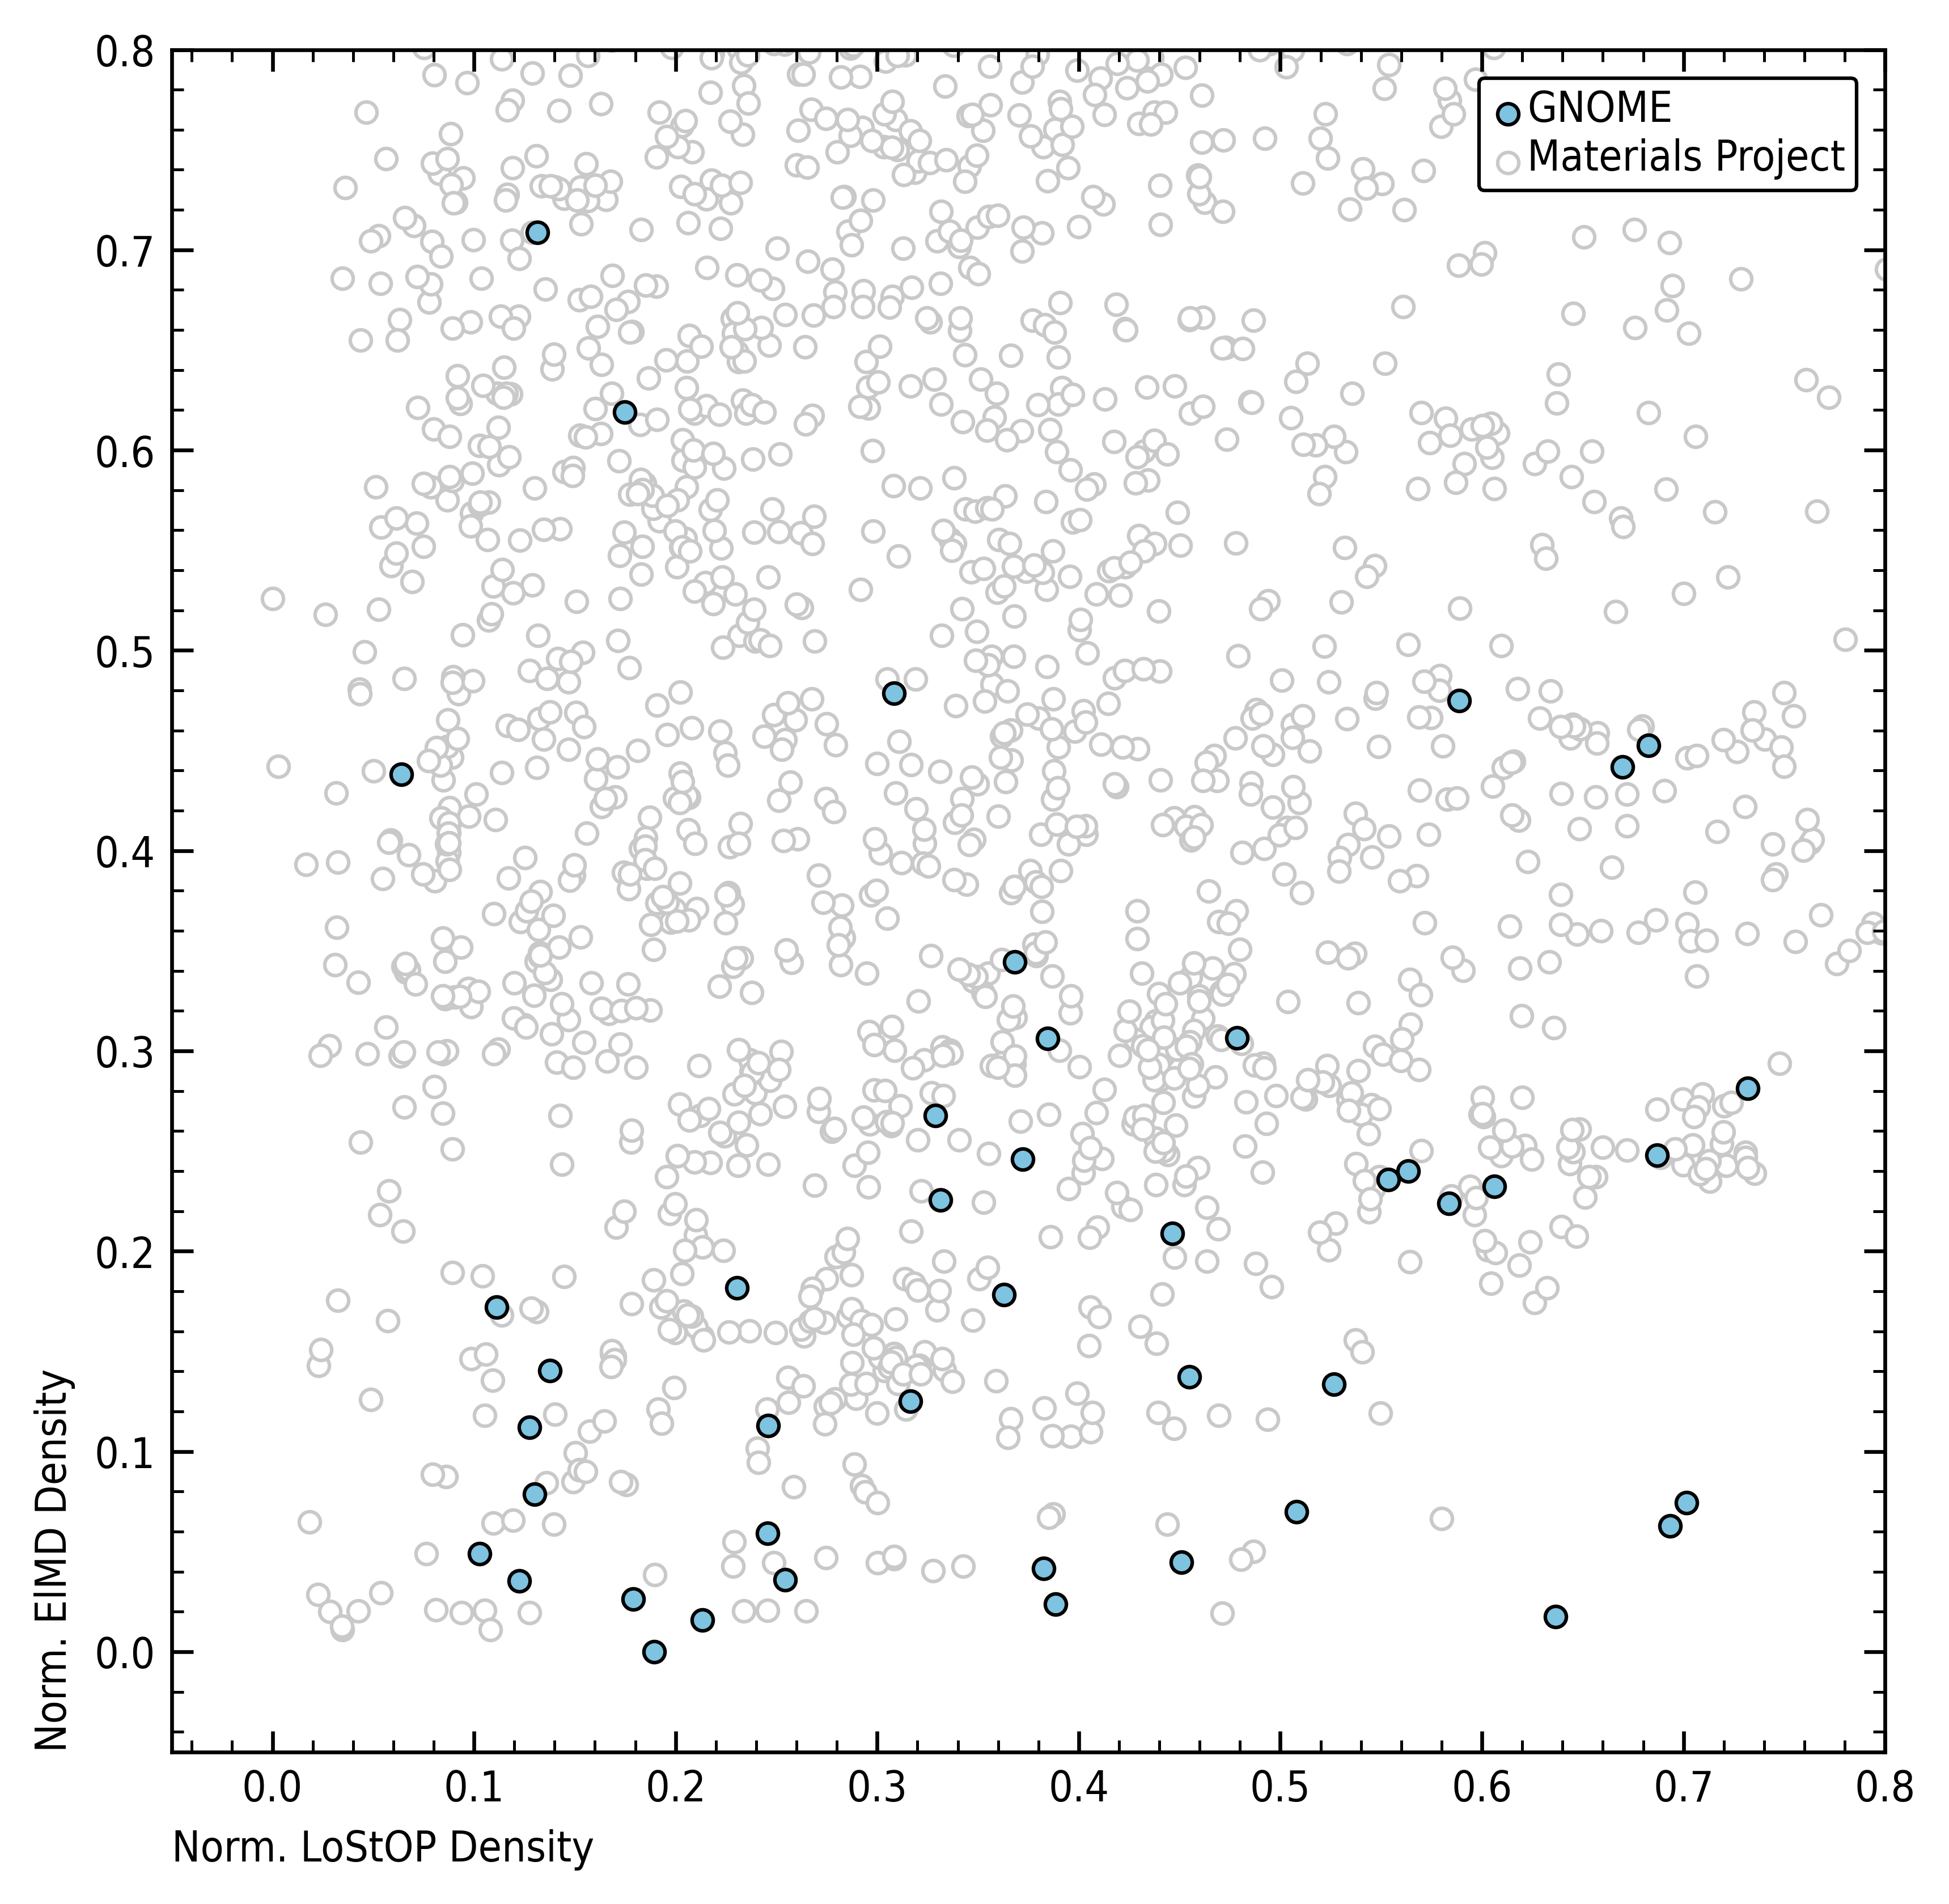

In [28]:

scaled_df = df.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

G_idx = np.where(data['mp'] == 0)[0]

fig, ax = plt.subplots(figsize=(6.5, 6.5), dpi=600)

# Plot all points
for i in range(len(df)):
    ax.scatter(
        scaled_df['lostop_density'].iloc[i],
        scaled_df['elmd_density'].iloc[i],
        fc='#7EC3E0' if i in G_idx else 'w',
        # fc='#E0877E' if i in G_idx else 'w',
        ec='k' if i in G_idx else '#c9c9c9',
        s=20,
        zorder=10 if i in G_idx else 1,
        lw=0.75
    )

ax.scatter([],[], fc='#7EC3E0', ec='k', lw=0.75, s=20, label='GNOME')
ax.scatter([],[], fc='w', ec='#c9c9c9', lw=0.75, s=20, label='Materials Project')

legend = ax.legend(loc='upper right', fontsize=6, frameon=True, framealpha=1.0, labelspacing=0.25)
legend.get_frame().set_linewidth(0.75)

ax.set_xlim(None, 0.8)
ax.set_ylim(None, 0.8)

ax.set_xlabel("Norm. LoStOP Density", loc='left')
ax.set_ylabel("Norm. ElMD Density", loc='bottom')

apply_condensed_font(fig)

plt.show()

In [ ]:
count = np.array([56, 20, 10])

10/ count.sum() # ortho 23%, tet 11%


0.11627906976744186

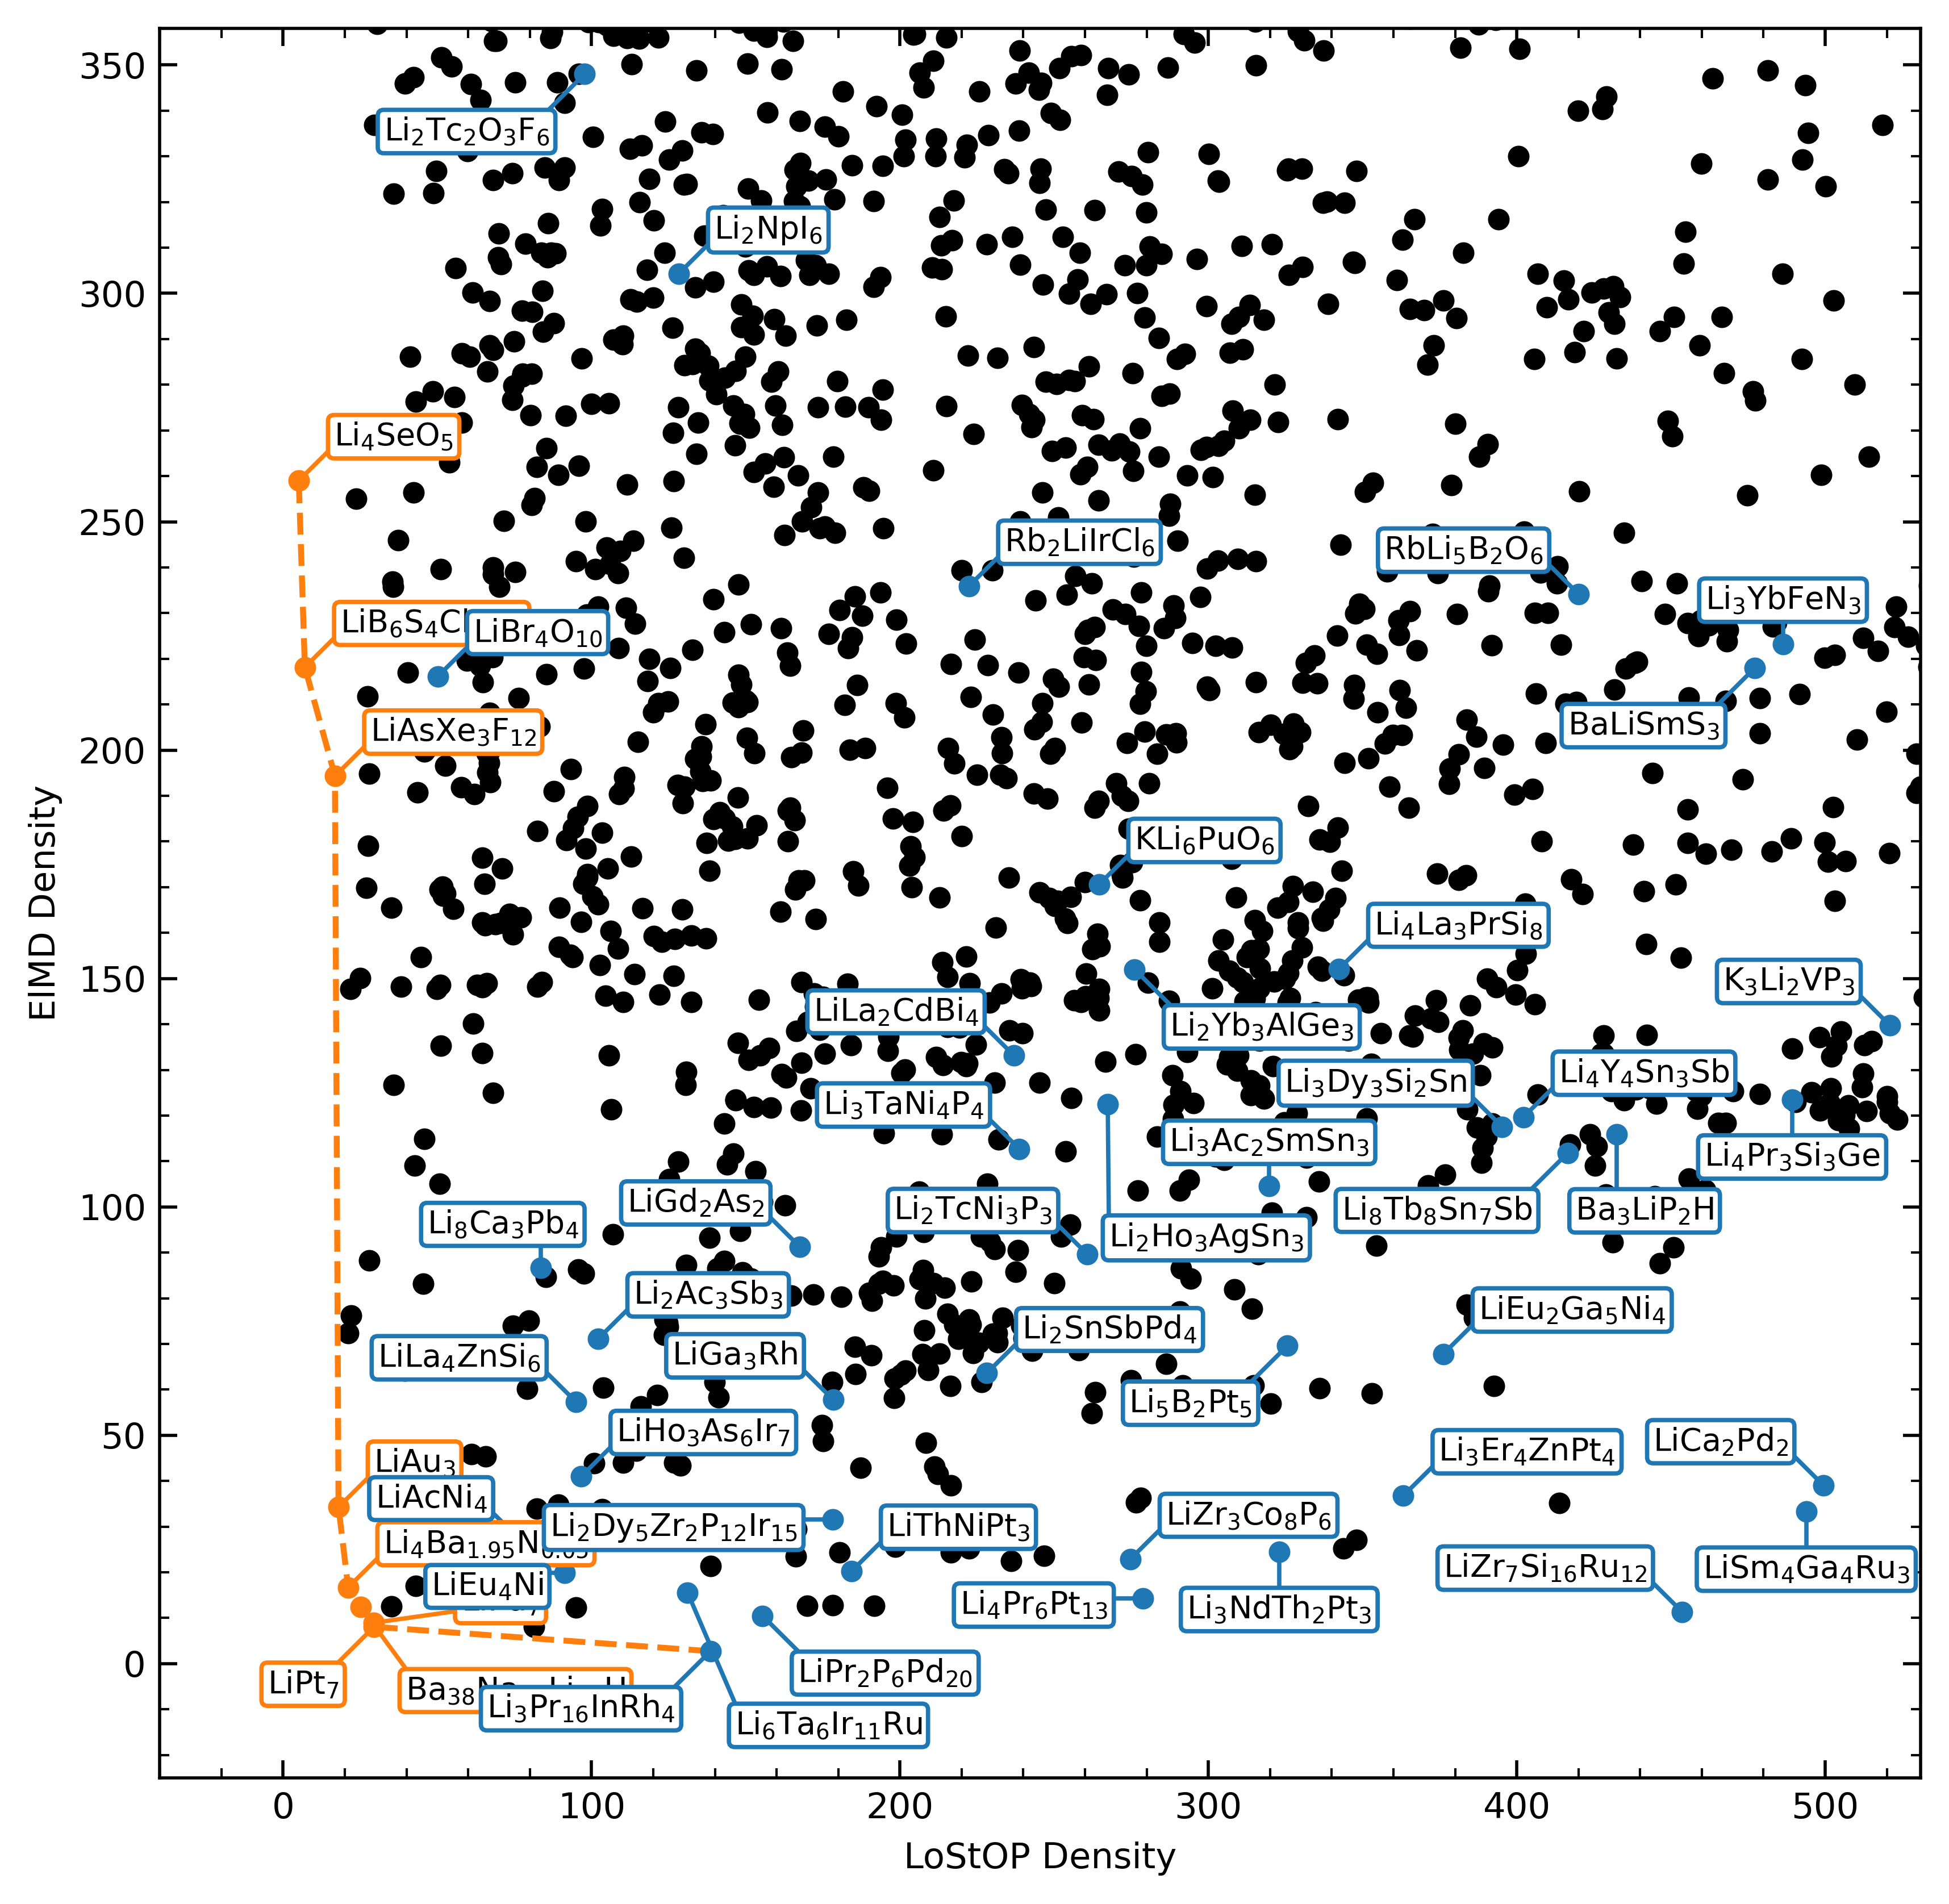

In [6]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=500)

p_idx = is_pareto_efficient(df[['lostop_density', 'elmd_density']].values, return_mask=False)

G_idx = np.where(data['mp'] == 0)[0]

# Plot all points
for i in range(len(df)):
    ax.scatter(
        df['lostop_density'].iloc[i],
        df['elmd_density'].iloc[i],
        color='C1' if i in p_idx and i not in G_idx else 'C0' if i in G_idx else 'k',
        s=20,
        zorder=10 if i in G_idx else 1,
    )


plt.xlim(-40, np.max(df.loc[G_idx, 'lostop_density']) + 10)
plt.ylim(-25, np.max(df.loc[G_idx, 'elmd_density']) + 10)
# plt.xlim(-40, 710)
# plt.ylim(-25, 500)

pareto_x = df['lostop_density'].loc[p_idx]
pareto_y = df['elmd_density'].loc[p_idx]

# sort by pareto_y
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))

ax.plot(pareto_x, pareto_y, color='C1', lw=1.5, ls='--', marker='None')

# now I want to label the pareto points and the GNOME points

labels = [reduce_single_formula(formula) for formula in df['formula'].values]
# if filename has "[" in it, prepend the text within "[ ]"
for i, label in enumerate(labels):
    if "[" in data['filename'].values[i]:
        labels[i] = "$_{" + data['filename'].values[i].split(']')[0].split('[')[1] + "}$" + str(label)

# if any p_idx is in G_idx, remove it
p_idx = np.array([i for i in p_idx if i not in G_idx])

pareto_labels = [labels[i] for i in p_idx]

pareto_labels[1] = "Li$_{4}$Ba$_{1.95}$N$_{0.05}$"
pareto_labels[6] = "Ba$_{38}$Na$_{58}$Li$_{26}$H"

ta.allocate(ax,
            x=df['lostop_density'].loc[p_idx],
            y=df['elmd_density'].loc[p_idx],
            text_list=pareto_labels,
            x_scatter=df['lostop_density'].loc[p_idx].values,
            y_scatter=df['elmd_density'].loc[p_idx].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            margin=0.012,
            textsize=8,
            nbr_candidates=10000,
            linecolor='C1',
            linewidth=1.1,
            min_distance=0.02,
            # max_distance=0.03,
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="C1", pad=0.19, lw=1.1),
            zorder=25,
            )

GNOME_labels = [labels[i] for i in G_idx]

ta.allocate(ax,
            x=df['lostop_density'].loc[G_idx],
            y=df['elmd_density'].loc[G_idx],
            text_list=GNOME_labels,
            x_scatter=df['lostop_density'].loc[G_idx].values,
            y_scatter=df['elmd_density'].loc[G_idx].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            margin=0.012,
            textsize=8,
            # verticalalignment='top',
            nbr_candidates=10000,
            linecolor='C0',
            linewidth=1.1,
            min_distance=0.02,
            # max_distance=0.03,
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="C0", pad=0.19, lw=1.1),
            zorder=25,
            )

# Set labels
plt.rcParams['svg.fonttype'] = 'none'
ax.set_xlabel("LoStOP Density")
ax.set_ylabel("ElMD Density")
plt.show()